<h1>Human Augmentics Project</h1>
<h2>Error in Speech Augmentation</h2>

<h4>Import libraries to be used</h4>

In [52]:
#Measuring Errors Comparing to the proper baseline for correct speech
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
import librosa.display
from dtw import dtw
from numpy.linalg import norm
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h3>Load Files and process them</h3>
<p>
    In this part of the code we upload the baseline audio which is a file of the expected pronunciation of the utterance ragarding rate.
    We extract the MFCC coefficients and duration of the audio to be used later
</p>

In [176]:
#file names
audio_baseline = 'original.wav'
#array with initial name of recorded audios (k=Kristina, a=Alpa, v=Recorded voice from: https://www.naturalreaders.com/online/) 
#and adjusted using Audacity software
#the files names follow this pattern: name+level-number.wav, so when you create a new audio file and want to process it add the name
#to the following array
audio_errors = ['k','a','v','aa']

#an array indicating the gender classification of each audio
# f for Female, m for Male
#everytime you add a new file you have to write the gender label here for correct mapping
audio_genders = ['F','F','M', 'M']
#path where audios with different levels are located. Note: you have to change this to point to your local directory
path = '../ha_project/'

# files that are going to be created
# Final Data csv file name
path_final_data = path+'/levels/final_data.csv'
# Error scale csv file name
path_scale_data = path+'/levels/scale_data.csv'
# Audio files for levels of error  path
path_audio_files = path+'/levels/'

# Set the sample rate we want to use to read our audio files
sample_rate = 44100

#create a table showing the coefficients and the difference of coefficients of errors audio respect to baseline
error_table_comparison = dict()
error_table_comparison['File name'] = list()
error_table_comparison['Levels'] = list()
error_table_comparison['Samples'] = list()
error_table_comparison['Sample Rate'] = list()
error_table_comparison['MFC Coefficients'] = list()
error_table_comparison['Sum of Coefficients'] = list()
error_table_comparison['DTW'] = list()
error_table_comparison['Gender'] = list()
error_table_comparison['Duration'] = list()
error_table_comparison['DurationDiff'] = list()
#load baseline audio
baseline_samples, baseline_sample_rate = librosa.load(path_audio_files+audio_baseline, sr=sample_rate)
#extract the mfcc coefficients from the baseline audio
baseline_mfcc = librosa.feature.mfcc(baseline_samples, baseline_sample_rate)
#calculate thte distance related to the baseline, in this case we use the same coefficients because we are comparing
#the same audio file 

baseline_dist, baseline_cost, baseline_acc_cost, baseline_path = dtw(baseline_mfcc.T, baseline_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))

#add baseline audio data to the table 
error_table_comparison['File name'].append(audio_baseline)
error_table_comparison['Levels'].append('baseline')
error_table_comparison['Samples'].append(baseline_samples)
error_table_comparison['Sample Rate'].append(baseline_sample_rate)
error_table_comparison['MFC Coefficients'].append(baseline_mfcc)
error_table_comparison['Sum of Coefficients'].append(np.sum(baseline_mfcc))
error_table_comparison['DTW'].append(baseline_dist) 
error_table_comparison['Gender'].append('F')

baseline_duration = len(baseline_samples)/baseline_sample_rate

error_table_comparison['Duration'].append(baseline_duration)
error_table_comparison['DurationDiff'].append(baseline_duration-baseline_duration)

print(baseline_dist, np.mean(baseline_cost), np.mean(baseline_acc_cost),np.mean(baseline_path))

0.0 505.730619488 35024.4514412 115.0


<h3>Plot the baseline waveform and MFCC values</h3>

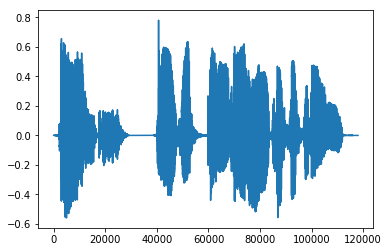

In [154]:
plot(baseline_samples)

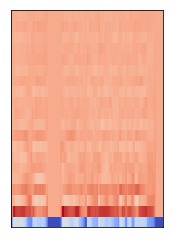

In [153]:
plot(baseline_mfcc)
subplot(1, 2, 1)
librosa.display.specshow(baseline_mfcc)

<h3>Load recorded audio files and process them</h3>
<p>
    In this the pre-recorded audio files are processed collecting information like duration, mfcc, duration difference against the baseline audio and so on.
    Information is stored in a Dictionary.
</p>

In [177]:
#FOR EACH AUDIO ERROR
#Extract the coefficients and other data from each audio.
#Also extract the DTW comparing the error audio against the baseline audio
#Once finished lets create a dataframe with all this information and save it as a csv file for further analysis
for file_number in [0,1,2,3,4]:
    gender_index = 0
    for filename in audio_errors:
        #tmp filename
        tmp_file_name = filename+str(file_number)+'.wav'
        #add the file name to the dictionary
        error_table_comparison['File name'].append(tmp_file_name)
        error_table_comparison['Levels'].append('Level-'+str(file_number))
        #load audio
        error_audio_samples, error_audio_sample_rate = librosa.load(path_audio_files+tmp_file_name, sr=sample_rate)
        #add info to the table
        error_table_comparison['Samples'].append(error_audio_samples)
        error_table_comparison['Sample Rate'].append(error_audio_sample_rate)
        #extract the mfcc coefficients from the audio with augmented error
        error_audio_mfcc = librosa.feature.mfcc(error_audio_samples, error_audio_sample_rate)
        error_table_comparison['MFC Coefficients'].append(error_audio_mfcc)
        error_table_comparison['Sum of Coefficients'].append(np.sum(error_audio_mfcc))
        #compare the augmented error file with the baseline file
        #Applying Dynamic Time Warping to measure similarity between two temporal sequences
        # Euclidean Distance
        error_audio_dist, error_audio_cost, error_audio_acc_cost, error_audio_path = dtw(baseline_mfcc.T, error_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
        error_table_comparison['DTW'].append(error_audio_dist) 
        error_table_comparison['Gender'].append(audio_genders[gender_index])
        error_file_duration = len(error_audio_samples)/error_audio_sample_rate
        error_table_comparison['Duration'].append(error_file_duration)
        error_table_comparison['DurationDiff'].append(error_file_duration - baseline_duration)
        gender_index = gender_index+1

<h3>Create DataFrames with the information collected about the recorded Audios</h3>
<p>
    Add all the information with the corresponding level and file name
</p>

In [178]:

final_data = pd.DataFrame(error_table_comparison)
#saving data to file
#if you want to add all the columns like Samples and MFC Coefficients just write the column name 
#between quotation marks
final_data = final_data[['File name','Levels','Sample Rate','Sum of Coefficients','DTW','Gender','Duration','DurationDiff']]


# Build a scale table averaging information created above for each error level
# Save the information into a csv file for further analysis
error_table_scale = dict()
error_table_scale['Level'] = list()
error_table_scale['Avg-coef'] = list()
error_table_scale['Avg-dtw'] = list()
error_table_scale['Avg-duration'] = list()
error_table_scale['Avg-duration-diff'] = list()

for level_number in ['0','1','2','3','4']:
    #temp_array = [x for x in error_table_comparison if x['Levels']== 'Level-'+level_number]
    temp_list_dtw = list()
    temp_list_coef = list()
    temp_list_duration = list()
    temp_list_duration_diff = list()
    error_table_scale['Level'].append('Level-'+level_number)
    for index, value in enumerate(error_table_comparison['Levels']):
        if(value=='Level-'+level_number):
            temp_list_dtw.append(error_table_comparison['DTW'][index])
            temp_list_coef.append(error_table_comparison['Sum of Coefficients'][index])
            temp_list_duration.append(error_table_comparison['Duration'][index])
            temp_list_duration_diff.append(error_table_comparison['DurationDiff'][index])
            
    error_table_scale['Avg-coef'].append(np.average(temp_list_coef))
    error_table_scale['Avg-dtw'].append(np.average(temp_list_dtw))
    error_table_scale['Avg-duration'].append(np.average(temp_list_duration))
    error_table_scale['Avg-duration-diff'].append(np.average(temp_list_duration_diff))

#saving data to file
scale_table = pd.DataFrame(error_table_scale)

<h3>Information collected from audio files</h3>

In [179]:
#printing data 
final_data.head(22)

,File name,Levels,Sample Rate,Sum of Coefficients,DTW,Gender,Duration,DurationDiff
0,original.wav,baseline,44100,-48016.391331,0.000000,F,2.675465,0.000000
1,k0.wav,Level-0,44100,-140084.202632,233.094343,F,3.771905,1.096440
2,a0.wav,Level-0,44100,-118125.932739,238.994272,F,3.152132,0.476667
3,v0.wav,Level-0,44100,-54885.110537,143.859480,M,3.013741,0.338277
4,aa0.wav,Level-0,44100,-133779.589229,238.737962,M,4.355624,1.680159
5,k1.wav,Level-1,44100,-237255.316532,288.961683,F,5.592109,2.916644
6,a1.wav,Level-1,44100,-151284.278361,289.204161,F,4.412971,1.737506
7,v1.wav,Level-1,44100,-75937.933205,147.956132,M,3.751927,1.076463
8,aa1.wav,Level-1,44100,-85525.341936,250.702080,M,4.838481,2.163016
9,k2.wav,Level-2,44100,-276739.159359,303.380231,F,6.460249,3.784785


<h3>Create another dataset with data averaged by level</h3>

In [180]:
scale_table[['Avg-coef', 'Avg-dtw', 'Avg-duration', 'Avg-duration-diff','Level']]

,Avg-coef,Avg-dtw,Avg-duration,Avg-duration-diff,Level
0,-111718.708784,213.671514,3.573350,0.897885,Level-0
1,-137500.717508,244.206014,4.648872,1.973407,Level-1
2,-181667.617314,259.256198,5.809478,3.134014,Level-2
3,-211889.100502,277.979268,7.459632,4.784167,Level-3
4,-300927.722783,293.087277,9.856661,7.181196,Level-4


<h3>Create another dataset with information regarding the range of values for each level</h3>

In [182]:
# Calculate max min for the scale and clasification
increment_value_dtw = (scale_table.loc[4,'Avg-dtw'] - scale_table.loc[0,'Avg-dtw'])/len(scale_table['Avg-dtw'])
list_min_dtw = list()
list_max_dtw = list()
list_min_duration = list()
list_max_duration = list()
list_min_duration_diff = list()
list_max_duration_diff = list()

# Calculate range
last_index = len(scale_table['Avg-coef'])-1
last_diff = 0 
for index, row in scale_table.iterrows():
    if index is not last_index:
        diff_avg = (scale_table['Avg-dtw'][index+1]-row['Avg-dtw'])/2
        diff_duration = (scale_table['Avg-duration'][index+1]-row['Avg-duration'])/2
        diff_duration_diff = (scale_table['Avg-duration-diff'][index+1]-row['Avg-duration-diff'])/2
        list_min_dtw.append(row['Avg-dtw']-diff_avg)
        list_min_duration.append(row['Avg-duration']-diff_duration)
        list_min_duration_diff.append(row['Avg-duration-diff']-diff_duration_diff)
        last_diff = diff_avg
    else:
        list_min_dtw.append(row['Avg-dtw']-diff_avg)
        list_min_duration.append(row['Avg-duration']-diff_duration)
        list_min_duration_diff.append(row['Avg-duration-diff']-diff_duration_diff)

scale_table['min-dtw'] = list_min_dtw
scale_table['min-duration'] = list_min_duration
scale_table['min-duration-diff'] = list_min_duration_diff

# Compute Max
for index, row in scale_table.iterrows():
    if index is not last_index:
        list_max_dtw.append(scale_table['min-dtw'][index+1])
        list_max_duration.append(scale_table['min-duration'][index+1])
        list_max_duration_diff.append(scale_table['min-duration-diff'][index+1])
    else:
        list_max_dtw.append(row['Avg-dtw']+increment_value_dtw)
        list_max_duration.append(row['Avg-duration']+2)
        list_max_duration_diff.append(row['Avg-duration-diff']+2)

scale_table['max-dtw'] = list_max_dtw
scale_table['max-duration'] = list_max_duration
scale_table['max-duration-diff'] = list_max_duration_diff

In [183]:
final_scale_table = scale_table[['Avg-coef', 'Avg-dtw', 'Avg-duration', 'Avg-duration-diff', 'min-dtw', 'max-dtw','min-duration','max-duration','min-duration-diff','max-duration-diff','Level']].copy()

<h3>The resulted table will be used when decided what is the level of error of the speech input</h3>

In [184]:
final_scale_table.columns = ['MFCC', 'DTW', 'Duration','DurationDiff','Min-DTW','Max-DTW','Min-Dur','Max-Dur','Min-Dur-d','Max-Dur-d','Level']
final_scale_table

,MFCC,DTW,Duration,DurationDiff,Min-DTW,Max-DTW,Min-Dur,Max-Dur,Min-Dur-d,Max-Dur-d,Level
0,-111718.708784,213.671514,3.573350,0.897885,198.404264,236.680922,3.035590,4.068569,0.360125,1.393104,Level-0
1,-137500.717508,244.206014,4.648872,1.973407,236.680922,249.894663,4.068569,4.984402,1.393104,2.308937,Level-1
2,-181667.617314,259.256198,5.809478,3.134014,249.894663,270.425264,4.984402,6.261117,2.308937,3.585652,Level-2
3,-211889.100502,277.979268,7.459632,4.784167,270.425264,285.533272,6.261117,8.658146,3.585652,5.982681,Level-3
4,-300927.722783,293.087277,9.856661,7.181196,285.533272,308.970429,8.658146,11.856661,5.982681,9.181196,Level-4


<h3>Load a pre-recorded audio, get required information and compare them against our table to determine the level of error</h3>

<p>The same process will be done against the speech input</p>

In [185]:
playing_file = audio_errors[1]+"1.wav"

input_samples, input_sample_rate = librosa.load(path_audio_files+playing_file, sr=sample_rate)
input_mfcc = librosa.feature.mfcc(input_samples, input_sample_rate)
input_dist, input_cost, input_acc_cos, input_path = dtw(baseline_mfcc.T, input_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
input_duration = len(input_samples)/input_sample_rate
input_diff_duration = input_duration - baseline_duration

print(input_dist, input_duration, input_diff_duration)

289.204160655 4.41297052154195 1.73750566893424


<h3>Function to determine the level of error in the input speech<h3>

In [186]:
#MFCC DTW Duration DurationDiff Min-DTW Max-DTW Min-Dur Max-Dur Min-Dur-d Max-Dur-d Level
def determine_level(dtw_distance, duration, diff_against_baseline):
    level_result = None
    for index, row in final_scale_table.iterrows():
        # for each row lets ask if the input data information falls in some level
        result = [-1,-1,-1]
        if row['Min-DTW'] <= dtw_distance <= row['Max-DTW']:
            result[0] = 1
        if row['Min-Dur'] <= duration <= row['Max-Dur']:
            result[1] = 1
        if row['Min-Dur-d'] <= diff_against_baseline <= row['Max-Dur-d']:
            result[2] = 1
        if sum(result) >= 1:
            #level found
            level_result = row['Level']
    if level_result is None:
        if dtw_distance < final_scale.loc[0,'DTW']:
            level_result = 'no-error'
        else:
            level_result = 'default-error'
    return level_result        

In [187]:
determine_level(input_dist, input_duration, input_diff_duration)

'Level-1'

<h2>Let's use that information to return the file to be played back to the user</h2>

In [190]:
# filter our data table 
def get_file_play_back(level, input_dist):
    level_number = int(level.split('-')[1])
    if level_number<4:
        # let's choose the audio that is the next in the level of errors
        possible_audio_files = final_data[final_data['Levels'] == 'Level-'+str(level_number+1)]
        
        for index, row in possible_audio_files.iterrows():
            if input_dist >= row['DTW']:
                result = row['File name']
                break
    return result

In [191]:
result = get_file_play_back(determine_level(input_dist, input_duration, input_diff_duration), input_dist)
result

'a2.wav'

In [192]:
from playsound import playsound

In [194]:
playsound(path_audio_files+'a1.wav')
playsound(path_audio_files+result)

In [195]:
final_data.to_csv(path_final_data, index=False)
final_scale_table.to_csv(path_scale_data, index=False)